
<a id='numerical-linear-algebra'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Numerical Linear Algebra and Factorizations

## Contents

- [Numerical Linear Algebra and Factorizations](#Numerical-Linear-Algebra-and-Factorizations)  
  - [Overview](#Overview)  
  - [Factorizations](#Factorizations)  
  - [Continuous Time Markov Chains (CTMC)](#Continuous-Time-Markov-Chains-%28CTMC%29)  
  - [Banded Matrices](#Banded-Matrices)  
  - [Implementation Details and Performance](#Implementation-Details-and-Performance)  
  - [Exercises](#Exercises)  

> You cannot learn too much linear algebra. – Benedict Gross

## Overview

In this lecture, we examine the structure of matrices and linear operators (e.g., dense, sparse, symmetric, tridiagonal, banded) and
discuss how the structure can be exploited to radically increase the performance of solving large problems.

We build on applications discussed in previous lectures: [linear algebra](linear_algebra.html), [orthogonal projections](orth_proj.html), and [Markov chains](finite_markov.html).

The methods in this section are called direct methods, and they are qualitatively similar to performing Gaussian elimination to factor matrices and solve systems of equations.  In [iterative methods and sparsity](iterative_methods_sparsity.html) we examine a different approach, using iterative algorithms, where we can think of more general linear operators.

The list of specialized packages for these tasks is enormous and growing, but some of the important organizations to
look at are [JuliaMatrices](https://github.com/JuliaMatrices) , [JuliaSparse](https://github.com/JuliaSparse), and [JuliaMath](https://github.com/JuliaMath)

*NOTE*: As this section uses advanced Julia techniques, you may wish to review multiple-dispatch and generic programming in  introduction to types, and consider further study on [generic programming](../more_julia/generic_programming.html).

The theme of this lecture, and numerical linear algebra in general, comes down to three principles:

1. **identify structure** (e.g. [symmetric, sparse, diagonal,etc.](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/index.html#Special-matrices-1)) of matrices in order to use **specialized algorithms**  
1. **do not lose structure** by applying the wrong linear algebra operations at the wrong times (e.g. sparse matrix becoming dense)  
1. understand the **computational complexity** of each algorithm, given the structure  

### Setup

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.6.0")
# uncomment to force package installation and precompilation
# github_project("QuantEcon/quantecon-notebooks-julia", version="0.6.0", instantiate=true, precompile = true)

In [2]:
using LinearAlgebra, Statistics, BenchmarkTools, SparseArrays, Random
Random.seed!(42);  # seed random numbers for reproducibility

### Computational Complexity

Ask yourself whether the following is a **computationally expensive** operation as the matrix **size increases**

- Multiplying two matrices?  
  
  - *Answer*: It depends.  Multiplying 2 diagonal matrices is trivial.  
  
- Solving a linear system of equations?  
  
  - *Answer*: It depends.  If the matrix is the identity, the solution is the vector itself.  
  
- Finding the eigenvalues of a matrix?  
  
  - *Answer*: It depends.  The eigenvalues of a triangular matrix are the diagonal.  
  


As the goal of this section is to move towards numerical methods with large systems, we need to understand how well algorithms scale with the size of matrices/vectors/etc.  This is known as [computational complexity](https://en.wikipedia.org/wiki/Computational_complexity).  As we saw in the answer to the questions above, the algorithm - and hence the computational complexity - changes based on matrix structure.

While this notion of complexity can work at various levels such as the number of [significant digits](https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Arithmetic_functions) for basic mathematical operations, the amount of memory and storage required, or the amount of time - we will typically focus on the time-complexity.

For time-complexity, the size $ N $ is usually the dimensionality of the problem, although occasionally the key will be the number of non-zeros in the matrix or width of bands.  For our applications, time-complexity is best thought of as the number of floating point operations (e.g. add, multiply, etc.) required.

#### Notation

Complexity of algorithms is typically written in [Big O](https://en.wikipedia.org/wiki/Big_O_notation) notation which provides bounds on the scaling.

Formally, if the number of operations required for a problem size $ N $ is $ f(N) $, we  can write this as $ f(N) = O(g(N)) $ for some $ g(N) $ - typically a polynomial.

The interpretation is that there exists some constants $ M $ and $ N_0 $ such that

$$
f(N) \leq M g(N), \text{ for } N > N_0
$$

For example, the complexity of finding an LU Decomposition of a dense matrix is $ O(N^3) $ which should be read as there being a constant where
eventually the number of floating point operations required decompose a matrix of size $ N\times N $ grows cubically.

Keep in mind that these are asymptotic results intended to understanding the scaling of the problem, and the constant can matter for a given
fixed size.

For example, the number of operations required for an [LU decomposition](https://en.wikipedia.org/wiki/LU_decomposition#Algorithms) of a dense $ N \times N $ matrix is $ f(N) = \frac{2}{3} N^3 $, ignoring the $ N^2 $ and lower terms.  Other methods of solving a linear system may have different constants of proportionality, even if they have the same scaling $ O(N^3) $.

### Rules of Computational Complexity

You will sometimes need to think through how [combining algorithms](https://en.wikipedia.org/wiki/Big_O_notation#Properties) changes complexity.  For example, if you use

1. an $ O(N^3) $ operation $ P $ times, then it simply changes the constant. The complexity remains $ O(N^3) $  
1. one $ O(N^3) $ operation and another $ O(N^2) $ one, then you take the max.  The complexity remains $ O(N^3) $  
1. a repetition of a $ O(N) $ operation that itself uses an $ O(N) $ one, you take the product.  The complexity becomes $ O(N^2) $  


With this, we have an important word of caution: dense matrix-multiplication is an [expensive operation](https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Matrix_algebra) for unstructured matrices, and the basic version is $ O(N^3) $.

Of course, modern libraries use highly tuned and numerically stable [algorithms](https://en.wikipedia.org/wiki/Matrix_multiplication_algorithm) to multiply matrices and exploit the computer architecture, memory cache, etc., but this simply lowers the constant of proportionality and they remain $ O(N^3) $.

A consequence is that, since many algorithms require matrix-matrix multiplication, it is often not possible to go below that order without further matrix structure.

That is, changing the constant of proportionality for a given size can help, but in order to achieve higher scaling you need to identify matrix structure (e.g. tridigonal, sparse, etc.) and ensure your operations do not lose it.

### Losing Structure

As a first example of a structured matrix, consider a [sparse arrays](https://docs.julialang.org/en/v1/stdlib/SparseArrays/index.html).

In [3]:
A = sprand(10, 10, 0.45)  # random sparse 10x10, 45 percent filled with non-zeros

@show nnz(A)  # counts the number of non-zeros
invA = sparse(inv(Array(A)))  # julia won't invert sparse so convert to dense with Array.
@show nnz(invA);

nnz(A) = 47
nnz(invA) = 

100


This increase from less than 50 to 100 percent dense demonstrates that significant sparsity can be lost when calculating an inverse.

The results can be even more extreme.  Consider a tridiagonal matrix of size $ N \times N $
that might come out of a Markov Chain or discretization  of a diffusion process,

In [4]:
N = 5
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2);])

5×5 Tridiagonal{Float64,Array{Float64,1}}:
 0.8  0.2   ⋅    ⋅    ⋅ 
 0.1  0.8  0.1   ⋅    ⋅ 
  ⋅   0.1  0.8  0.1   ⋅ 
  ⋅    ⋅   0.1  0.8  0.1
  ⋅    ⋅    ⋅   0.2  0.8

The number of non-zeros here is approximately $ 3 N $, linear, which scales well for huge matrices into the millions or billions

But consider the inverse

In [5]:
inv(A)

5×5 Array{Float64,2}:
  1.29099      -0.327957     0.0416667  -0.00537634   0.000672043
 -0.163978      1.31183     -0.166667    0.0215054   -0.00268817
  0.0208333    -0.166667     1.29167    -0.166667     0.0208333
 -0.00268817    0.0215054   -0.166667    1.31183     -0.163978
  0.000672043  -0.00537634   0.0416667  -0.327957     1.29099

Now, the matrix is fully dense and has $ N^2 $ non-zeros.

This also applies to the $ A' A $ operation if forming the normal equations of linear-least squares.

In [6]:
A = sprand(20, 21, 0.3)
@show nnz(A)/20^2
@show nnz(A'*A)/21^2;

nnz(A) / 20 ^ 2 = 0.2825
nnz(A' * A) / 21 ^ 2 = 

0.800453514739229


We see that a 30 percent dense matrix becomes almost full dense after the product is taken.

*Sparsity/Structure is not just for storage*:  Matrix size can sometimes become important (e.g. a 1 million by 1 million tridiagonal matrix needs to store 3 million numbers (i.e, about 6MB of memory), where a dense one requires 1 trillion (i.e., about 1TB of memory).

But, as we will see, the main purpose of considering sparsity and matrix structure is that it enables specialized algorithms which typically
have a lower-computational order than unstructured dense, or even an unstructured sparse operations.

First, create a convenient functions for benchmarking linear solvers

In [7]:
using BenchmarkTools
function benchmark_solve(A, b)
    println("A\\b for typeof(A) = $(string(typeof(A)))")
    @btime $A \ $b
end

benchmark_solve (generic function with 1 method)

Then, take away structure to see the impact on performance,

In [8]:
N = 1000
b = rand(N)
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2);])
A_sparse = sparse(A)  # sparse but losing tridiagonal structure
A_dense = Array(A)    # dropping the sparsity structure, dense 1000x1000

# benchmark solution to system A x = b
benchmark_solve(A, b)
benchmark_solve(A_sparse, b)
benchmark_solve(A_dense, b);

A\b for typeof(A) = Tridiagonal{Float64,Array{Float64,1}}


  29.478 μs (9 allocations: 47.75 KiB)
A\b for typeof(A) = SparseMatrixCSC{Float64,Int64}


  741.454 μs (69 allocations: 1.06 MiB)
A\b for typeof(A) = Array{Float64,2}


  32.368 ms (5 allocations: 7.65 MiB)


This example shows what is at stake:  using a structured tridiagonal may be 10-20x faster than using a sparse matrix which is 100x faster then
using a dense matrix.

In fact, the difference becomes more extreme as the matrices grow.  Solving a tridiagonal system is $ O(N) $ while that of a dense matrix without any structure is $ O(N^3) $.  The complexity of a sparse solution is more complicated, and scales in part by the `nnz(N)`, i.e. the number of nonzeros.

### Matrix Multiplication

While we write matrix multiplications in our algebra with abandon, in practice the operation scales very poorly without any matrix structure.

Matrix multiplication is so important to modern computers that the constant of scaling is small using proper packages, but the order is still $ O(N^3) $ in practice.

Sparse matrix multiplication, on the other hand, is $ O(N M_A M_B) $ where $ M_A $ are the number of nonzeros per row of $ A $ and $ B $ are the number of non-zeros per column of $ B $.

By the rules of computational order, that means any algorithm requiring a matrix multiplication of dense matrices requires at least $ O(N^3) $ operation.

The other important question is what is the structure of the resulting matrix.  For example, multiplying an upper triangular by a lower triangular

In [9]:
N = 5
U = UpperTriangular(rand(N,N))

5×5 UpperTriangular{Float64,Array{Float64,2}}:
 0.299976  0.176934  0.0608682  0.20465   0.409653
  ⋅        0.523923  0.127154   0.512531  0.235328
  ⋅         ⋅        0.600588   0.682868  0.330638
  ⋅         ⋅         ⋅         0.345419  0.0312986
  ⋅         ⋅         ⋅          ⋅        0.471043

In [10]:
L = U'

5×5 Adjoint{Float64,UpperTriangular{Float64,Array{Float64,2}}}:
 0.299976   0.0       0.0       0.0        0.0
 0.176934   0.523923  0.0       0.0        0.0
 0.0608682  0.127154  0.600588  0.0        0.0
 0.20465    0.512531  0.682868  0.345419   0.0
 0.409653   0.235328  0.330638  0.0312986  0.471043

But the product is fully dense (e.g. think of a cholesky multiplied by itself to produce a covariance matrix)

In [11]:
L * U

5×5 Array{Float64,2}:
 0.0899855  0.0530758  0.018259   0.0613901  0.122886
 0.0530758  0.305801   0.0773883  0.304736   0.195775
 0.018259   0.0773883  0.380579   0.487749   0.253435
 0.0613901  0.304736   0.487749   0.890193   0.441042
 0.122886   0.195775   0.253435   0.441042   0.555378

On the other hand, a tridiagonal times a diagonal is still a tridiagonal - and can use specialized $ O(N) $ algorithms.

In [12]:
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2);])
D = Diagonal(rand(N))
D * A

5×5 Tridiagonal{Float64,Array{Float64,1}}:
 0.0156225  0.00390564   ⋅           ⋅          ⋅ 
 0.0436677  0.349342    0.0436677    ⋅          ⋅ 
  ⋅         0.0213158   0.170526    0.0213158   ⋅ 
  ⋅          ⋅          0.00790566  0.0632453  0.00790566
  ⋅          ⋅           ⋅          0.19686    0.787442

## Factorizations

When you tell a numerical analyst you are solving a linear system using direct methods, their first question is “which factorization?”.

Just as you can factorize a number (e.g. $ 6 = 3 \times 2 $) you can factorize a matrix as the product of other, more
convenient matrices (e.g. $ A = L U $ or $ A = Q R $ where $ L, U, Q, $ and $ R $ have properties such as being triangular or [orthogonal](https://en.wikipedia.org/wiki/Orthogonal_matrix), etc.).

### Inverting Matrices

On paper, since the [Invertible Matrix Theorem](https://en.wikipedia.org/wiki/Invertible_matrix#The_invertible_matrix_theorem) tells us a unique solution is
equivalent to $ A $ being invertible, we often write the solution to $ A x = b $ as

$$
x = A^{-1} b
$$

What if we do not (directly) use a factorization?

Take a simple linear system of a dense matrix,

In [13]:
N = 4
A = rand(N,N)
b = rand(N)

4-element Array{Float64,1}:
 0.5682240701809245
 0.40245385575255055
 0.1825995192132288
 0.06160128039631019

On paper, we to solve for $ A x = b $ by inverting the matrix,

In [14]:
x = inv(A) * b

4-element Array{Float64,1}:
 -0.0339069840407679
  0.7988200873225003
  0.9963711951331815
 -0.9276352098500461

As we will see throughout, inverting matrices should be used for theory, not for code.  The classic advice that you should [never invert a matrix](https://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix) may be [slightly exaggerated](https://arxiv.org/abs/1201.6035), but is generally good advice.

Solving a system by inverting a matrix is always a little slower, potentially less accurate, and will sometimes lose crucial sparsity compared to using factorizations.  Moreover, the methods used by libraries to invert matrices are frequently the same factorizations used for computing a system of equations.

Even if you need to solve a system with the same matrix multiple times, you are better off factoring the matrix and using the solver rather than calculating an inverse.

In [15]:
N = 100
A = rand(N,N)
M = 30
B = rand(N,M)
function solve_inverting(A, B)
    A_inv = inv(A)
    X = similar(B)
    for i in 1:size(B,2)
        X[:,i] = A_inv * B[:,i]
    end
    return X
end

function solve_factoring(A, B)
    X = similar(B)
    A = factorize(A)
    for i in 1:size(B,2)
        X[:,i] = A \ B[:,i]
    end
    return X
end



@btime solve_inverting($A, $B)
@btime solve_factoring($A, $B)

# even better, use built-in feature for multiple RHS
@btime $A \ $B;

  489.444 μs (68 allocations: 205.28 KiB)


  399.048 μs (96 allocations: 155.59 KiB)


  216.410 μs (6 allocations: 102.63 KiB)


### Triangular Matrices and Back/Forward Substitution

Some matrices are already in a convenient form and require no further factoring.

For example, consider solving a system with an `UpperTriangular` matrix,

In [16]:
b = [1.0, 2.0, 3.0]
U = UpperTriangular([1.0 2.0 3.0; 0.0 5.0 6.0; 0.0 0.0 9.0])

3×3 UpperTriangular{Float64,Array{Float64,2}}:
 1.0  2.0  3.0
  ⋅   5.0  6.0
  ⋅    ⋅   9.0

This system is especially easy to solve using [back-substitution](https://en.wikipedia.org/wiki/Triangular_matrix#Forward_and_back_substitution).  In particular, $ x_3 = b_3 / U_{33}, x_2 = (b_2 - x_3 U_{23})/U_{22} $, etc.

In [17]:
U \ b

3-element Array{Float64,1}:
 0.0
 0.0
 0.3333333333333333

A `LowerTriangular` has similar properties and can be solved with forward-substitution.

The computational order of back-substitution and forward-substitution is $ O(N^2) $ for dense matrices.  Those fast algorithms are a key reason that factorizaitons target triangular structures.


<a id='jl-decomposition'></a>

### LU Decomposition

The $ LU $ decompositions finds a lower triangular $ L $ and upper triangular $ U $ such that $ L U = A $.

For a general dense matrix without any other structure (i.e. not known to be symmetric, tridiagonal, etc.) this is the standard approach to solve a system and exploit the speed of backward and forward substitution using the factorization.

The computational order of LU decomposition itself for a dense matrix is $ O(N^3) $ - the same as Gaussian elimination, but it tends
to have a better constant term than others (e.g. half the number of operations of the QR Decomposition).  For structured
or sparse matrices, that order drops.

We can see which algorithm Julia will use for the `\` operator by looking at the `factorize` function for a given
matrix.

In [18]:
N = 4
A = rand(N,N)
b = rand(N)

Af = factorize(A)  # chooses the right factorization, LU here

LU{Float64,Array{Float64,2}}
L factor:
4×4 Array{Float64,2}:
 1.0       0.0       0.0       0.0
 0.563082  1.0       0.0       0.0
 0.730109  0.912509  1.0       0.0
 0.114765  0.227879  0.115228  1.0
U factor:
4×4 Array{Float64,2}:
 0.79794  0.28972   0.765939   0.496278
 0.0      0.82524   0.23962   -0.130989
 0.0      0.0      -0.447888   0.374303
 0.0      0.0       0.0        0.725264

In this case, it provides an $ L $ and $ U $ factorization (with [pivoting](https://en.wikipedia.org/wiki/LU_decomposition#LU_factorization_with_full_pivoting) ).

With the factorization complete, we can solve different `b` right hand sides.

In [19]:
Af \ b

4-element Array{Float64,1}:
 -0.49842605495731557
 -0.11835721499695576
  1.5055538550184817
  0.07694455957797537

In [20]:
b2 = rand(N)
Af \ b2

4-element Array{Float64,1}:
 -0.6456780666059364
 -0.2601515737654759
  1.116889566296631
  0.5405293106660054

In practice, the decomposition also includes a $ P $ is a [permutation matrix](https://en.wikipedia.org/wiki/Permutation_matrix) such
that $ P A = L U $.

In [21]:
Af.P * A ≈ Af.L * Af.U

true

We can also directly calculate an `lu` decomposition without the pivoting,

In [22]:
L, U = lu(A, Val(false))  # the Val(false) provides solution without permutation matrices

LU{Float64,Array{Float64,2}}
L factor:
4×4 Array{Float64,2}:
 1.0       0.0       0.0       0.0
 0.730109  1.0       0.0       0.0
 0.563082  1.09588   1.0       0.0
 0.114765  0.249728  0.122733  1.0
U factor:
4×4 Array{Float64,2}:
 0.79794  0.28972    0.765939   0.496278
 0.0      0.753039  -0.229233   0.254774
 0.0      0.0        0.490832  -0.410191
 0.0      0.0        0.0        0.725264

And we can verify the decomposition

In [23]:
A ≈ L * U

true

To see roughly how the solver works, note that we can write the problem $ A x = b $ as $ L U x = b $.  Let $ U x = y $, which breaks the
problem into two sub-problems.

$$
\begin{aligned}
L y &= b\\
U x &= y
\end{aligned}
$$

As we saw above, this is the solution to two triangular systems, which can be efficiently done with back or forward substitution in $ O(N^2) $ operations.

To demonstrate this, first using

In [24]:
y = L \ b

4-element Array{Float64,1}:
  0.759344042755733
 -0.4146467815590597
  0.707411438334498
  0.05580508465599857

In [25]:
x = U \ y
x ≈ A \ b  # Check identical

true

The LU decomposition also has specialized algorithms for structured matrices, such as a `Tridiagonal`

In [26]:
N = 1000
b = rand(N)
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2);])
factorize(A) |> typeof

LU{Float64,Tridiagonal{Float64,Array{Float64,1}}}

This factorization is the key to the performance of the `A \ b` in this case.  For Tridiagonal matrices, the
LU decomposition is $ O(N^2) $.

Finally, just as a dense matrix without any structure use an LU decomposition to solve a system,
so will the sparse solvers

In [27]:
A_sparse = sparse(A)
factorize(A_sparse) |> typeof  # dropping the tridiagonal structure to just become sparse

SuiteSparse.UMFPACK.UmfpackLU{Float64,Int64}

In [28]:
benchmark_solve(A, b)
benchmark_solve(A_sparse, b);

A\b for typeof(A) = Tridiagonal{Float64,Array{Float64,1}}


  30.204 μs (9 allocations: 47.75 KiB)
A\b for typeof(A) = SparseMatrixCSC{Float64,Int64}


  730.537 μs (69 allocations: 1.06 MiB)


With sparsity, the computational order is related to the number of non-zeros rather than the size of the matrix itself.

### Cholesky Decomposition

For real, symmetric, [positive definitive](https://en.wikipedia.org/wiki/Definiteness_of_a_matrix) matrices, a Cholesky decomposition is a specialized example of the LU decomposition where $ L = U' $.

The Cholesky is directly useful on its own (e.g. [Classical Control with Linear Algebra](../time_series_models/classical_filtering.html)) but it is also an efficient factorization to solve symmetric positive definite system.

As always, symmetry allows specialized algorithms.

In [29]:
N = 500
B = rand(N,N)
A_dense = B' * B  # an easy way to generate a symmetric positive definite matrix
A = Symmetric(A_dense)  # flags the matrix as symmetric

factorize(A) |> typeof

BunchKaufman{Float64,Array{Float64,2}}

Here, the $ A $ decomposition is [Bunch-Kaufman](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/index.html#LinearAlgebra.bunchkaufman) rather than a
Cholesky, because Julia doesn’t know the matrix is positive definite.  We can manually factorize with a Cholesky,

In [30]:
cholesky(A) |> typeof

Cholesky{Float64,Array{Float64,2}}

Benchmarking,

In [31]:
b = rand(N)
cholesky(A) \ b  # use the factorization to solve

benchmark_solve(A, b)
benchmark_solve(A_dense, b)
@btime cholesky($A, check=false) \ $b;

A\b for typeof(A) = Symmetric{Float64,Array{Float64,2}}


  5.035 ms (8 allocations: 2.16 MiB)
A\b for typeof(A) = Array{Float64,2}


  6.897 ms (5 allocations: 1.92 MiB)


  3.188 ms (7 allocations: 1.91 MiB)


### QR Decomposition

Previously, we learned about applications of the QR application to solving the linear least squares.

While in principle, the solution to the least-squares problem

$$
\min_x \| Ax -b \|^2
$$

is $ x = (A'A)^{-1}A'b $, in practice note that $ A'A $ becomes dense and calculating the inverse is rarely a good idea.

The QR decomposition is a decomposition $ A = Q R $ where $ Q $ is an orthogonal matrix (i.e. $ Q'Q = Q Q' = I $) and $ R $ is
a upper triangular matrix.

Given the  previous derivation we showed that we can write the least squares problem as
the solution to

$$
R x = Q' b
$$

Where, as discussed above, the upper-triangular structure of $ R $ can be solved easily with back substitution.

The `\` operator solves the linear-least squares problem whenever the given `A` is rectangular

In [32]:
N = 10
M = 3
x_true = rand(3)

A = rand(N,M) .+ randn(N)
b = rand(N)
x = A \ b

3-element Array{Float64,1}:
  0.4011747124872585
  0.0736108001071848
 -0.2347806801272458

To manually use the QR decomposition in solving linear least squares:

In [33]:
Af = qr(A)
Q = Af.Q
R = [Af.R; zeros(N - M, M)] # Stack with zeros
@show Q * R ≈ A
x = R \ Q'*b  # simplified QR solution for least squares

Q * R ≈ A = true


3-element Array{Float64,1}:
  0.4011747124872585
  0.07361080010718478
 -0.2347806801272457

This stacks the `R` with zeros, but the more specialized algorithm would not multiply directly
in that way.

In some cases, if an LU is not available for a particular matrix structure, the QR factorization
can also be used to solve systems of equations (i.e. not just LLS).  This tends to be about 2x slower than the LU,
but is of the same computational order.

Deriving the approach, where we can now use inverse since the system is square and we assumed $ A $ was non-singular

$$
\begin{aligned}
A x &= b\\
Q R x &= b\\
Q^{-1} Q R x &= Q^{-1} b\\
R x &= Q' b
\end{aligned}
$$

Where the last step uses that $ Q^{-1} = Q' $ for an orthogonal matrix.

Given the decomposition, the solution for dense matrices is of computational
order $ O(N^2) $.  To see this, look at the order of each operation.

- Since $ R $ is upper-triangular matrix, it can be solved quickly through back substitution with computational order $ O(N^2) $  
- A transpose operation is of order $ O(N^2) $  
- A matrix-vector product is also $ O(N^2) $  


In all cases, the order would drop depending on the sparsity pattern of the
matrix (and corresponding decomposition).  A key benefit of a QR decomposition is that it tends to
maintain sparsity.

Without implementing the full process, you can form a QR
factorization with `qr` and then use it to solve a system

In [34]:
N = 5
A = rand(N,N)
b = rand(N)
@show A \ b
@show qr(A) \ b;

A \ b = [-1.478040941944558, 2.09875752634393, -0.6857071090150306, -0.16849538664184543, 2.012803045177841]
qr(A) \ b = [-1.4780409419445582, 2.09875752634393, -0.685707109015032, -0.16849538664184413, 2.0128030451778414]


### Spectral Decomposition

A spectral decomposition, also known as an [eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix), finds all of the eigenvectors and eigenvalues to decompose a square matrix `A` such that

$$
A = Q \Lambda Q^{-1}
$$

where $ Q $ is a matrix made of the the eigenvectors of $ A $ as columns, and $ \Lambda $ is a diagonal matrix of the eigenvalues.  Only square, [diagonalizable](https://en.wikipedia.org/wiki/Diagonalizable_matrix) matrices have an eigendecomposition (where a matrix is not diagonalizable if it does not have a full set of linearly independent eigenvectors).

In Julia, whenever you ask for a full set of eigenvectors and eigenvalues, it  decomposes using an algorithm appropriate for the matrix type.  For example, symmetric, hermitian, or tridiagonal matrices have specialized algorithms.

To see this,

In [35]:
A = Symmetric(rand(5, 5))  # symmetric matrices have real eigenvectors/eigenvalues
A_eig = eigen(A)
Λ = Diagonal(A_eig.values)
Q = A_eig.vectors
norm(Q * Λ * inv(Q) - A)

2.803627108839096e-15

Keep in mind that a real matrix may have complex eigenvalues and eigenvectors, so if you attempt  to check `Q * Λ * inv(Q) - A` - even for a positive-definite matrix - it may not be a real due number due to numerical inaccuracy.

## Continuous Time Markov Chains (CTMC)

In the previous lecture on discrete time Markov chains, we saw that the transition probability
between state $ x $ and state $ y $ was summarized by the matrix $ P(x, y) := \mathbb P \{ X_{t+1} = y \,|\, X_t = x \} $.

As a brief introduction to continuous time processes, consider the same state-space as in the discrete
case: $ S $ a finite set with $ n $ elements $ \{x_1, \ldots, x_n\} $.

A **Markov chain** $ \{X_t\} $ on $ S $ is a sequence of random variables on $ S $ that have the **Markov property**.

In continuous time, the [Markov Property](https://en.wikipedia.org/wiki/Markov_property) is more complicated, but intuitively is
the same as the discrete time case.

That is, knowing the current state is enough to know probabilities for future states.  Or, for realizations $ x(\tau)\in S, \tau \leq t $,

$$
\mathbb P \{ X(t+s) = y  \,|\, X(t) = x, X(\tau) = x(\tau) \text{ for } 0 \leq \tau \leq t  \} = \mathbb P \{ X(t+s) = y  \,|\, X(t) = x\}
$$

Heuristically, consider a time period $ t $ and a small step forward $ \Delta $.  Then the probability to transition from state $ i $ to
state $ j $ is

$$
\mathbb P \{ X(t + \Delta) = j  \,|\, X(t) \} = \begin{cases} q_{ij} \Delta + o(\Delta) & i \neq j\\
                                                              1 + q_{ii} \Delta + o(\Delta) & i = j \end{cases}
$$

where $ q_{ij} $ are “intensity” parameters governing the transition rate, and $ o(\Delta) $ is [little-o notation](https://en.wikipedia.org/wiki/Big_O_notation#Little-o_notation).  That is, $ \lim_{\Delta\to 0} o(\Delta)/\Delta = 0 $.

Just as in the discrete case, we can summarize these parameters by a $ N \times N $ matrix, $ Q \in R^{N\times N} $.

Recall that in the discrete case every element is weakly positive and every row must sum to one.   Instead, with a continuous time the rows of $ Q $ sum to zero, where the diagonal contains the negative value of jumping out of the current state.  That is

- $ q_{ij} \geq 0 $ for $ i \neq j $  
- $ q_{ii} \leq 0 $  
- $ \sum_{j} q_{ij} = 0 $  


The $ Q $ matrix is called the intensity matrix, or the infinitesimal generator of the Markov chain.  For example,

$$
Q = \begin{bmatrix} -0.1 & 0.1  & 0 & 0 & 0 & 0\\
                    0.1  &-0.2  & 0.1 &  0 & 0 & 0\\
                    0 & 0.1 & -0.2 & 0.1 & 0 & 0\\
                    0 & 0 & 0.1 & -0.2 & 0.1 & 0\\
                    0 & 0 & 0 & 0.1 & -0.2 & 0.1\\
                    0 & 0 & 0 & 0 & 0.1 & -0.1\\
    \end{bmatrix}
$$

In that example, transitions only occur between adjacent states with the same intensity (except for a ``bouncing’’ back of the bottom and top states).

Implementing the $ Q $ using its tridiagonal structure

In [36]:
using LinearAlgebra
α = 0.1
N = 6
Q = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))

6×6 Tridiagonal{Float64,Array{Float64,1}}:
 -0.1   0.1    ⋅     ⋅     ⋅     ⋅ 
  0.1  -0.2   0.1    ⋅     ⋅     ⋅ 
   ⋅    0.1  -0.2   0.1    ⋅     ⋅ 
   ⋅     ⋅    0.1  -0.2   0.1    ⋅ 
   ⋅     ⋅     ⋅    0.1  -0.2   0.1
   ⋅     ⋅     ⋅     ⋅    0.1  -0.1

Here we can use the `Tridiagonal` to exploit the structure of the problem.

Consider a simple payoff vector $ r $ associated with each state, and a discount rate $ ρ $.  Then we can solve for
the expected present discounted value in a similar way to the discrete time case.

$$
\rho v = r + Q v
$$

or rearranging slightly, solving the linear system

$$
(\rho I - Q) v = r
$$

For our example, exploiting the tridiagonal structure,

In [37]:
r = range(0.0, 10.0, length=N)
ρ = 0.05

A = ρ * I - Q

6×6 Tridiagonal{Float64,Array{Float64,1}}:
  0.15  -0.1     ⋅      ⋅      ⋅      ⋅ 
 -0.1    0.25  -0.1     ⋅      ⋅      ⋅ 
   ⋅    -0.1    0.25  -0.1     ⋅      ⋅ 
   ⋅      ⋅    -0.1    0.25  -0.1     ⋅ 
   ⋅      ⋅      ⋅    -0.1    0.25  -0.1
   ⋅      ⋅      ⋅      ⋅    -0.1    0.15

Note that this $ A $ matrix is maintaining the tridiagonal structure of the problem, which leads to an efficient solution to the
linear problem.

In [38]:
v = A \ r

6-element Array{Float64,1}:
  38.15384615384615
  57.23076923076923
  84.92307692307693
 115.07692307692311
 142.76923076923077
 161.84615384615384

The $ Q $ is also used to calculate the evolution of the Markov chain, in direct analogy to the $ ψ_{t+k} = ψ_t P^k $ evolution with transition matrix $ P $ of the discrete case.

In the continuous case, this becomes the system of linear differential equations

$$
\dot{ψ}(t) = Q(t)^T ψ(t)
$$

given the initial condition $ \psi(0) $ and where the $ Q(t) $ intensity matrix is allows to vary with time.  In the simplest case of a constant $ Q $ matrix, this is a simple constant-coefficient system of linear ODEs with coefficients $ Q^T $.

If a stationary equilibria exists, note that $ \dot{ψ}(t) = 0 $, and the stationary solution $ ψ^{*} $ needs to fulfill

$$
0 = Q^T ψ^{*}
$$

Notice that this is of the form $ 0 ψ^{*} = Q^T ψ^{*} $ and hence is equivalent to finding the eigenvector associated with the $ \lambda = 0 $ eigenvalue of $ Q^T $.

With our example, we can calculate all of the eigenvalues and eigenvectors

In [39]:
λ, vecs = eigen(Array(Q'))

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
6-element Array{Float64,1}:
 -0.3732050807568874
 -0.29999999999999993
 -0.19999999999999998
 -0.09999999999999995
 -0.026794919243112274
  0.0
vectors:
6×6 Array{Float64,2}:
 -0.149429  -0.288675   0.408248   0.5          -0.557678  0.408248
  0.408248   0.57735   -0.408248   1.38778e-16  -0.408248  0.408248
 -0.557678  -0.288675  -0.408248  -0.5          -0.149429  0.408248
  0.557678  -0.288675   0.408248  -0.5           0.149429  0.408248
 -0.408248   0.57735    0.408248   7.63278e-16   0.408248  0.408248
  0.149429  -0.288675  -0.408248   0.5           0.557678  0.408248

Indeed, there is a $ \lambda = 0 $ eigenvalue, which is associated with the last column in the eigenvector.  To turn that into a probability
we need to normalize it.

In [40]:
vecs[:,N] ./ sum(vecs[:,N])

6-element Array{Float64,1}:
 0.16666666666666657
 0.16666666666666657
 0.1666666666666667
 0.16666666666666682
 0.16666666666666685
 0.16666666666666663

### Multiple Dimensions

A frequent case in discretized models is dealing with Markov chains with multiple “spatial” dimensions (e.g. wealth and income).

After discretizing a process to create a Markov chain, you can always take the cartesian product of the set of states in order to
enumerate as a single state variable.

To see this, consider states $ i $ and $ j $ governed by infinitesimal generators $ Q $ and $ A $.

In [41]:
function markov_chain_product(Q, A)
    M = size(Q, 1)
    N = size(A, 1)
    Q = sparse(Q)
    Qs = blockdiag(fill(Q, N)...)  # create diagonal blocks of every operator
    As = kron(A, sparse(I(M)))
    return As + Qs
end

α = 0.1
N = 4
Q = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))
A = sparse([-0.1 0.1
    0.2 -0.2])
M = size(A,1)
L = markov_chain_product(Q, A)
L |> Matrix  # display as a dense matrix

8×8 Array{Float64,2}:
 -0.2   0.1   0.0   0.0   0.1   0.0   0.0   0.0
  0.1  -0.3   0.1   0.0   0.0   0.1   0.0   0.0
  0.0   0.1  -0.3   0.1   0.0   0.0   0.1   0.0
  0.0   0.0   0.1  -0.2   0.0   0.0   0.0   0.1
  0.2   0.0   0.0   0.0  -0.3   0.1   0.0   0.0
  0.0   0.2   0.0   0.0   0.1  -0.4   0.1   0.0
  0.0   0.0   0.2   0.0   0.0   0.1  -0.4   0.1
  0.0   0.0   0.0   0.2   0.0   0.0   0.1  -0.3

This provides the combined markov chain for the $ (i,j) $ process.  To see the sparsity pattern,

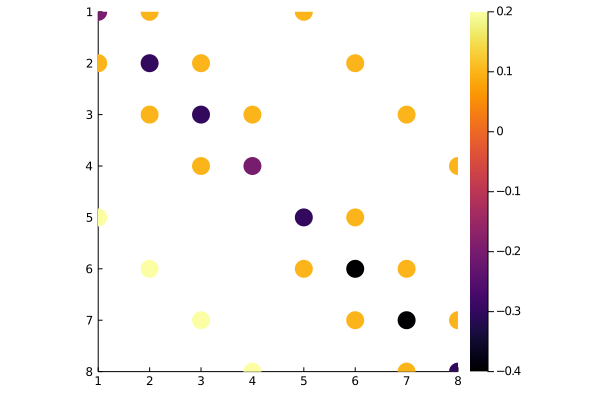

In [42]:
using Plots
spy(L, markersize = 10)

To calculate a simple dynamic valuation, consider if the payoff of being in state $ (i,j) $ is $ r_{ij} = i + 2j $

In [43]:
r = [i + 2.0j for i in 1:N, j in 1:M]
r = vec(r)  # vectorize it since stacked in same order

8-element Array{Float64,1}:
 3.0
 4.0
 5.0
 6.0
 5.0
 6.0
 7.0
 8.0

Solving the equation $ \rho v = r + L v $

In [44]:
ρ = 0.05
v = (ρ * I - L) \ r
reshape(v, N, M)

4×2 Array{Float64,2}:
  87.8992   93.6134
  96.1345  101.849
 106.723   112.437
 114.958   120.672

The `reshape` helps to rearrange it back to being two-dimensional.

To find the stationary distribution, we calculate the eigenvalue and choose the eigenvector associated with $ \lambda=0 $ .  In this
case, we can verify it is the last one.

In [45]:
L_eig = eigen(Matrix(L'))
@assert norm(L_eig.values[end]) < 1E-10

ψ = L_eig.vectors[:,end]
ψ = ψ / sum(ψ)

8-element Array{Float64,1}:
 0.16666666666666677
 0.1666666666666665
 0.16666666666666682
 0.16666666666666666
 0.08333333333333325
 0.08333333333333345
 0.0833333333333333
 0.08333333333333334

Reshaping this to be two dimensional if it is helpful for visualization

In [46]:
reshape(ψ, N, size(A,1))

4×2 Array{Float64,2}:
 0.166667  0.0833333
 0.166667  0.0833333
 0.166667  0.0833333
 0.166667  0.0833333

### Irreducibility

As with the discrete time Markov chains, a key question is whether CTMCs are reducible, i.e. states communicate.  The problem
is isomorphic to determining if the directed graph of the Markov chain is [strongly connected](https://en.wikipedia.org/wiki/Strongly_connected_component).

In [47]:
using LightGraphs
α = 0.1
N = 6
Q = Tridiagonal(fill(α, N-1), [-α; fill(-2α, N-2); -α], fill(α, N-1))

6×6 Tridiagonal{Float64,Array{Float64,1}}:
 -0.1   0.1    ⋅     ⋅     ⋅     ⋅ 
  0.1  -0.2   0.1    ⋅     ⋅     ⋅ 
   ⋅    0.1  -0.2   0.1    ⋅     ⋅ 
   ⋅     ⋅    0.1  -0.2   0.1    ⋅ 
   ⋅     ⋅     ⋅    0.1  -0.2   0.1
   ⋅     ⋅     ⋅     ⋅    0.1  -0.1

We can verify that it is possible to move between every state in a finite number of steps with

In [48]:
Q_graph = DiGraph(Q)
@show is_strongly_connected(Q_graph);  # i.e. can follow directional edges to get to every state

is_strongly_connected(Q_graph) = true


Alternatively, as an example of a reducible Markov chain where states $ 1 $ and $ 2 $ cannot jump to state $ 3 $.

In [49]:
Q = [-0.2 0.2 0
    0.2 -0.2 0
    0.2 0.6 -0.2]
Q_graph = DiGraph(Q)
@show is_strongly_connected(Q_graph);

is_strongly_connected(Q_graph) = false


## Banded Matrices

A tridiagonal matrix has 3 non-zero diagonals.  The main diagonal, the first sub-diagonal (i.e. below the main diagonal) and the also the first super-diagonal (i.e. above the main diagonal).

This is a special case of a more general type called a banded matrix, where the number of sub- and super-diagonals can be greater than 1.  The
total width of main-, sub-, and super-diagonals is called the bandwidth.  For example, a tridiagonal matrix has a bandwidth of 3.

A $ N \times N $ banded matrix with bandwidth $ P $ has about $ N P $ nonzeros in its sparsity pattern.

These can be created directly as a dense matrix with `diagm`.  For example, with a bandwidth of three and a zero diagonal.

In [50]:
diagm(1 => [1,2,3], -1 => [4,5,6])

4×4 Array{Int64,2}:
 0  1  0  0
 4  0  2  0
 0  5  0  3
 0  0  6  0

Or as a sparse matrix,

In [51]:
spdiagm(1 => [1,2,3], -1 => [4,5,6])

4×4 SparseMatrixCSC{Int64,Int64} with 6 stored entries:
  [2, 1]  =  4
  [1, 2]  =  1
  [3, 2]  =  5
  [2, 3]  =  2
  [4, 3]  =  6
  [3, 4]  =  3

Or, directly using [BandedMatrices.jl](https://github.com/JuliaMatrices/BandedMatrices.jl)

In [52]:
using BandedMatrices
BandedMatrix(1 => [1,2,3], -1 => [4,5,6])

4×4 BandedMatrix{Int64,Array{Int64,2},Base.OneTo{Int64}}:
 0  1  ⋅  ⋅
 4  0  2  ⋅
 ⋅  5  0  3
 ⋅  ⋅  6  0

There is also a convenience function for generating random banded matrices

In [53]:
A = brand(7, 7, 3, 1)  # 7x7 matrix, 3 subdiagonals, 1 subdiagonal

7×7 BandedMatrix{Float64,Array{Float64,2},Base.OneTo{Int64}}:
 0.386608  0.346262    ⋅         ⋅          ⋅          ⋅         ⋅ 
 0.479616  0.750276   0.50362    ⋅          ⋅          ⋅         ⋅ 
 0.857743  0.913585   0.087322  0.0676183   ⋅          ⋅         ⋅ 
 0.779364  0.293782   0.269804  0.813762   0.147221    ⋅         ⋅ 
  ⋅        0.0341229  0.711412  0.438157   0.0312296  0.930633   ⋅ 
  ⋅         ⋅         0.412892  0.351496   0.701733   0.335451  0.0827553
  ⋅         ⋅          ⋅        0.394056   0.460506   0.25927   0.418861

And, of course, specialized algorithms will be used to exploit the structure when solving linear systems.  In particular, the complexity is related to the $ O(N P_L P_U) $ for upper and lower bandwidths $ P $

In [54]:
@show factorize(Symmetric(A)) |> typeof
A \ rand(7)

factorize(Symmetric(A)) |> typeof = LDLt{Float64,Symmetric{Float64,BandedMatrix{Float64,Array{Float64,2},Base.OneTo{Int64}}}}


7-element Array{Float64,1}:
 -0.6345917189136551
  1.2689275835805582
  0.5499404721793494
  0.24947160343942412
 -0.45227412611006496
  0.4973200025591808
  1.3752489574369149

The factorization algorithm uses a specialized LU decomposition for banded matrices.


<a id='implementation-numerics'></a>

## Implementation Details and Performance

Recall the famous quote from Knuth: “97% of the time: premature optimization is the root of all evil. Yet we should not pass up our opportunities in that critical 3%”.  The most common example of premature optimization is trying to use your own mental model of a compiler while writing your code, worried about the efficiency of code and (usually incorrectly) second-guessing the compiler.

Concretely, the lessons in this section are

1. Don’t worry about optimizing your code unless you need to.  Code clarity is your first-order concern.  
1. If you use other people’s packages, they can worry about performance and you don’t need to.  
1. If you absolutely need that “critical 3%” your intuition about performance is usually wrong on modern CPUs and GPUs, so let the compiler do its job.  
1. Benchmarking (e.g. `@btime`) and [profiling](https://docs.julialang.org/en/v1/manual/profile/) are the tools to figure out performance bottlenecks.  If 99% of
  of computing time is spent in 1 small function, then there is no point optimizing anything else.  
1. If you benchmark to show that a particular part of the code is an issue, and you can’t find another library that does a better job, then you can worry about performance.  


You will rarely get to step 3, let alone step 5.

However, there is also a corollary:  “don’t pessimize prematurely”. That is, don’t make choices that lead to poor performance without any tradeoff in improved code clarity.  For example, writing your own algorithms when a high performance algorithm exists in a package or Julia itself, or lazily making a matrix dense and carelessly dropping its structure.

### Implementation Difficulty

Numerical analysis sometimes to refer to the lowest level of code for basic operations (e.g. a dot product, matrix-matrix product, convolutions) as `kernels`.

That sort of code is difficult to write, and performance depends on the characteristics of the underlying hardware such as the [instruction set](https://en.wikipedia.org/wiki/Instruction_set_architecture) available on the particular CPU, the size of the [CPU cache](https://en.wikipedia.org/wiki/CPU_cache), and the layout of arrays in memory.

Typically these operations are written in a [BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) library, organized into different levels.  The levels roughly correspond to the computational order of the operations:  BLAS Level 1 are $ O(N) $ operations such as linear products, Level 2 are $ O(N^2) $ operations such as matrix-vector products, and Level 3 are $ O(N^3) $ such as general matrix-matrix products.

An example of a BLAS library is [OpenBLAS](https://github.com/xianyi/OpenBLAS) used by default in Julia, or  the [Intel MKL](https://en.wikipedia.org/wiki/Math_Kernel_Library) used in Matlab (and Julia if the `MKL.jl` package is installed).

On top of BLAS are [LAPACK](https://en.wikipedia.org/wiki/LAPACK) operations, which are higher level kernels, such as matrix factorizations and eigenvalue algorithms, and are often in the same libraries (e.g. MKL has both BLAS and LAPACK functionality).

The details of these packages are not especially relevant, but if you are talking about performance, people will inevitably start discussing these different packages and kernels.  There are a few important things to keep in mind:

1. Leave writing kernels to the experts.  Even simple sounding algorithms can be very complicated to make high performance.  
1. Your intuition about performance of code is probably going to be wrong.  If you use high quality libraries rather than writing your own kernels, you don’t need to use your intuition.  
1. Don’t get distracted by the jargon or acronyms above if you are reading about performance.  

### Row and Column-Major Ordering

There is a practical performance issue which may influence your code.  Since memory in a CPU is linear, dense matrices need to be stored by either stacking columns (called [column-major order](https://en.wikipedia.org/wiki/Row-_and_column-major_order)) or rows.

The reason this matters is that compilers can generate better performance if they work in contiguous chunks of memory, and this becomes especially important with large matrices due to the interaction with the CPU cache.  Choosing the wrong order when there is no benefit in code clarity is a an example of premature pessimization.  The performance difference can be orders of magnitude in some cases, and nothing in others.

One option is to use the functions that let the compiler choose the most efficient way to traverse memory. If you need to choose the looping order yourself, then you might want to experiment with swapping whether you go through columns or rows first.  Other times, let Julia decide, i.e. `enumerate` and `eachindex` will choose the right approach.

Julia, Fortran, and Matlab all use column-major order while C/C++ and Python use row-major order.  This means that if you find an algorithm written for C/C++/Python you will sometimes need to make small changes if performance is an issue.

### Digression on Allocations and Inplace Operations

While we have usually not considered optimizing code for performance (and focused on the choice of
algorithms instead), when matrices and vectors become large we need to be more careful.

The most important thing to avoid are excess allocations, which usually occur due to the use of
temporary vectors and matrices when they are not necessary.  Sometimes those extra temporary values
can cause enormous degredations in performance.

However, caution is suggested since
excess allocations are never relevant for scalar values, and can sometimes create faster code for
smaller matrices/vectors since it can lead to better [cache locality](https://en.wikipedia.org/wiki/Locality_of_reference).

To see this, a convenient tool is the benchmarking

In [55]:
using BenchmarkTools
A = rand(10,10)
B = rand(10,10)
C = similar(A)
function f!(C, A, B)
    D = A*B
    C .= D .+ 1
end
@btime f!($C, $A, $B)

  516.647 ns (1 allocation: 896 bytes)


10×10 Array{Float64,2}:
 3.26172  4.24569  3.37182  4.10324  …  4.03344  4.39198  2.88797  2.63934
 4.19687  4.58126  3.88015  5.0409      4.0105   3.56832  2.35475  3.32362
 2.17535  2.58069  3.08736  3.04461     2.71563  3.03535  2.62734  2.37854
 4.07043  4.57067  4.23989  5.24296     4.34443  4.21237  3.30526  3.82245
 3.16928  4.20751  3.08482  3.89843     3.81516  4.14681  2.64178  2.94961
 3.01031  3.08903  2.83417  3.80852  …  3.22832  3.29357  2.57282  2.60746
 3.88276  4.45627  3.88941  5.12798     4.11822  3.70176  2.69528  3.81814
 2.7023   3.10147  2.95828  3.63363     3.64397  3.40609  2.44341  3.03272
 3.02687  3.13864  2.78748  3.90634     3.18422  2.90128  1.99457  2.80653
 3.80929  3.83031  3.88255  4.8596      4.16155  3.73634  2.65279  3.07034

The `!` on the `f!` is an informal way to say that the function is mutating, and the first arguments (`C` here)
is by convention the modified values.

In the `f!` function, notice that the `D` is a temporary variable which is created, and then modified afterwards.  But, notice that since
`C` is modified directly, there is no need to create the temporary `D` matrix.

This is an example of where an inplace version of the matrix multiplication can help avoid the allocation.

In [56]:
function f2!(C, A, B)
    mul!(C, A, B)  # in place multiplication
    C .+= 1
end
A = rand(10,10)
B = rand(10,10)
C = similar(A)
@btime f!($C, $A, $B)
@btime f2!($C, $A, $B)

  524.953 ns (1 allocation: 896 bytes)


  480.449 ns (0 allocations: 0 bytes)


10×10 Array{Float64,2}:
 2.42733  3.74571  2.5811   2.745    …  2.45258  3.17339  2.792    3.46213
 3.52188  4.16932  3.17155  3.98401     2.1202   2.85629  3.35848  3.88871
 3.74317  4.66988  3.3338   4.69372     2.61622  3.70894  4.06268  4.79582
 3.30158  4.09369  3.81428  3.65591     2.743    3.42494  3.65687  3.83879
 2.47181  4.33343  2.46863  2.68593     2.38238  3.6709   3.2434   4.17783
 3.5594   4.72281  3.71072  4.31957  …  2.83065  4.21896  4.34601  4.90251
 3.76742  4.85555  4.03515  4.55265     2.62424  4.19292  4.57003  4.88181
 3.29688  5.38813  3.4278   3.8622      2.87482  4.07336  3.89498  5.41919
 2.96602  3.60521  2.90236  3.2117      2.68528  2.99728  3.34362  3.47657
 4.73208  5.38525  4.42378  5.18235     2.91664  4.70184  5.28638  5.4401

Note in the output of the benchmarking, the `f2!` is non-allocating and is using the pre-allocated `C` variable directly.

Another example of this is solutions to linear equations, where for large solutions you may pre-callocate and reuse the
solution vector.

In [57]:
A = rand(10,10)
y = rand(10)
z = A \ y  # creates temporary

A = factorize(A)  # inplace requires factorization
x = similar(y)  # pre-allocate
ldiv!(x, A, y)  # inplace left divide, using factorization

10-element Array{Float64,1}:
 -0.09745394360765254
  0.7799354221131604
  1.1994346228906085
  0.0913844576787099
 -0.5083914639425638
 -0.3509162355608617
  0.793473061987608
 -0.5304171009174155
  0.4517444530913052
 -0.8005334538688558

However, if you benchmark carefully, you will see that this is sometimes slower.  Avoiding allocations is not always a good
idea - and worrying about it prior to benchmarking is premature optimization.

There are a variety of other non-allocating versions of functions.  For example,

In [58]:
A = rand(10,10)
B = similar(A)

transpose!(B, A)  # non-allocating version of B = transpose(A)

10×10 Array{Float64,2}:
 0.373481   0.715094  0.880197   0.219559   …  0.903144   0.0534784  0.646242
 0.0572854  0.437244  0.0465054  0.271735      0.0419775  0.91462    0.804396
 0.0722476  0.435665  0.631825   0.0804549     0.773098   0.254097   0.674881
 0.0341739  0.185395  0.736277   0.142816      0.687287   0.236726   0.19037
 0.843743   0.860459  0.709686   0.630887      0.274137   0.958363   0.948974
 0.918731   0.933097  0.280531   0.486534   …  0.0313851  0.479192   0.988241
 0.868133   0.243504  0.628518   0.954309      0.667845   0.935099   0.990551
 0.0636638  0.659151  0.377286   0.0453235     0.865368   0.64157    0.570134
 0.759633   0.389194  0.153783   0.284574      0.245533   0.516012   0.55121
 0.301123   0.505073  0.0402959  0.225074      0.57159    0.893165   0.374389

Finally, a common source of unnecessary allocations is when taking slices or portions of
matrices.  For example, the following allocates a new matrix `B` and copies the values.

In [59]:
A = rand(5,5)
B = A[2,:]  # extract a vector

5-element Array{Float64,1}:
 0.07265755245781103
 0.2967203620355736
 0.7745398448673058
 0.6244448536072318
 0.5287113274542306

To see these are different matrices, note that

In [60]:
A[2,1] = 100.0
@show A[2,1]
@show B[1];

A[2, 1] = 100.0
B[1] = 0.07265755245781103


Instead of allocating a new matrix, you can take a `view` of a matrix, which provides an
appropriate `AbstractArray` type that doesn’t allocate new memory with the `@view` matrix.

In [61]:
A = rand(5,5)
B = @view A[2,:]  #  does not copy the data

A[2,1] = 100.0
@show A[2,1]
@show B[1];

A[2, 1] = 100.0
B[1] = 100.0


But, again, you will often find that doing `@view` leads to slower code.  Benchmark
instead, and generally rely on it for large matrices and for contiguous chunks of memory (e.g. a column rather than a row).

## Exercises

### Exercise 1

This exercise is for a practice on writing low-level routines (i.e. “kernels”), and to hopefully convince you to leave low-level code to the experts.

The formula for matrix multiplication is deceptively simple.  For example, with the product of square matrices $ C = A B $ of size $ N \times N $, the $ i,j $ element of $ C $ is

$$
C_{ij} = \sum_{k=1}^N A_{ik} B_{kj}
$$

Alternatively, you can take a row $ A_{i,:} $ and column $ B_{:, j} $ and use an inner product

$$
C_{ij} = A_{i,:} \cdot B_{:,j}
$$

Note that the inner product in a discrete space is simply a sum, and has the same complexity as the sum (i.e. $ O(N) $ operations).

For a dense matrix without any structure, this also makes it clear why the complexity is $ O(N^3) $: you need to evaluate it for $ N^2 $ elements in the matrix and do an $ O(N) $ operation each time.

For this exercise, implement matrix multiplication yourself and compare performance in a few permutations.

1. Use the built-in function in Julia (i.e.``C = A * B`` or, for a better comparison, the inplace version `mul!(C, A, B)` which works with preallocated data)  
1. Loop over each $ C_{ij} $ by the row first (i.e. the `i` index) and use a `for` loop for the inner product  
1. Loop over each $ C_{ij} $ by the column first (i.e. the `j` index) and use a `for` loop for the inner product  
1. Do the same but use the `dot` product instead of the sum.  
1. Choose your best implementation of these, and then for matrices of a few different sizes `N=10`, `N=1000`, etc. and compare the ratio of performance of your best implementation to the built in BLAS library.  


A few more hints:

- You can just use random matrices, e.g. `A = rand(N, N)`, etc.  
- For all of them, preallocate the $ C $ matrix beforehand with `C = similar(A)` or something equivalent.  
- To compare performance, put your code in a function and use `@btime` macro to time it.  

### Exercise 2a

Here we will calculate the evolution of the pdf of a discrete time Markov Chain, $ \psi_t $ given the initial condition $ \psi_0 $.

Start with a simple symmetric tridiagonal matrix

In [62]:
N = 100
A = Tridiagonal([fill(0.1, N-2); 0.2], fill(0.8, N), [0.2; fill(0.1, N-2)])
A_adjoint = A';

1. Pick some large `T` and use the initial condition $ \psi_0 = \begin{bmatrix} 1 & 0 & \ldots & 0\end{bmatrix} $  
1. Write code to calculate $ \psi_t $ to some $ T $ by iterating the map for each $ t $, i.e.  


$$
\psi_{t+1} = A' \psi_t
$$

1. What is the computational order of that calculating  $ \psi_T $ using this iteration approach $ T < N $?  
1. What is the computational order of $ (A')^T = (A \ldots A) $ and then $ \psi_T = (A')^T \psi_0 $ for $ T < N $?  
1. Benchmark calculating $ \psi_T $ with the iterative calculation above as well as the direct $ \psi_T = (A')^T \psi_0 $ to see which is faster.  You can take the matrix power with just `A_adjoint^T`, which uses specialized algorithms faster and more accurate than repeated matrix multiplication (but with the same computational order).  
1. Check the same if $ T = 2 N $  


*Note:* The algorithm used in Julia to take matrix powers  depends on the matrix structure, as always.  In the symmetric case, it can use an eigendecomposition, whereas with a general dense matrix it uses [squaring and scaling](https://doi.org/10.1137/090768539).

### Exercise 2b

With the same setup as Exercise 2a, do an [eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) of `A_transpose`.  That is, use `eigen` to factorize the adjoint $ A' = Q \Lambda Q^{-1} $ where $ Q $ the matrix of eigenvectors and $ \Lambda $ the diagonal matrix of eigenvalues.  Calculate $ Q^{-1} $ from the results.

Use the factored matrix to calculate the sequence of $ \psi_t = (A')^t \psi_0 $ using the relationship

$$
\psi_t = Q \Lambda^t Q^{-1} \psi_0
$$

Where matrix powers of diagonal matrices are simply the element-wise power of each element.

Benchmark the speed of calculating the sequence of $ \psi_t $ up to `T = 2N` using this method.  In principle, the factorization and easy calculation of the power should give you benefits compared to simply iterating the map as we did in Exercise 2a.  Explain why it does or does not using computational order of each approach.